In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web 
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

### Stock data function configured to get past stock pricing information and drop all columns except 'Open', 'High', and 'Close'

In [4]:
def get_stock_data(stock_name, normalized=0):
    start = datetime.datetime(2013, 10, 20)
    end = datetime.datetime(2018, 11, 8)

    stocks = web.DataReader(stock_name, 'iex', start, end)
    df = pd.DataFrame(stocks)
    df.drop(['low', 'volume'], axis = 1, inplace=True)
    print(df.head())
    return df

In [5]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name, 0)

                open      high     close
date                                    
2013-11-08  504.8794  509.7593  508.5230
2013-11-11  505.2598  508.4730  505.8003
2013-11-12  504.3539  509.2888  506.3959
2013-11-13  503.8784  516.9414  516.7512
2013-11-14  517.4770  520.3949  518.1326


### Save the stock information to a CSV

In [6]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [7]:
df['high'] = df['high'] / 1000
df['open'] = df['open'] / 1000
df['close'] = df['close'] / 1000
print(df.head(5))

                open      high     close
date                                    
2013-11-08  0.504879  0.509759  0.508523
2013-11-11  0.505260  0.508473  0.505800
2013-11-12  0.504354  0.509289  0.506396
2013-11-13  0.503878  0.516941  0.516751
2013-11-14  0.517477  0.520395  0.518133


### Loading the data function

In [56]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = pd.DataFrame(stock).values
    sequence_length = seq_len + 1
    result = [] 
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_train, y_train, x_test, y_test]

### Building the model function

In [57]:
def build_model(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

### Setting X and Y for training and testing

In [58]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1128, 5, 3)
y_train (1128,)
X_test (125, 5, 3)
y_test (125,)


### Loading the model sequence structure


In [59]:
model = build_model([3, window, 1])

### Executing the model sequence structure

In [60]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=0)

In [61]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

Train Score: 0.00 MSE (0.02 RMSE)


In [62]:
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Test Score: 0.00 MSE (0.01 RMSE)


In [63]:
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

0 0.53843 0.5305016 0.01494509320767512 0.007928395919799769
1 0.52662 0.5314425 -0.00907440182877639 0.004822523002624535
2 0.5201699999999999 0.53255373 -0.02325348906949931 0.012383732395172209
3 0.518 0.5313239 -0.02507681193107214 0.013323909759521468
4 0.5225700000000001 0.52704775 -0.008495915798368503 0.00447775333404532
5 0.5353300000000001 0.5226524 0.024256298605532578 0.012677612380981529
6 0.53387 0.5207881 0.025119481656616705 0.013081926460266069
7 0.53853 0.5234032 0.028900801296034118 0.015126772670745803
8 0.53488 0.5275088 0.013973614856913397 0.0073712047386169655
9 0.5363300000000001 0.5312741 0.009516593997733969 0.005055919723510827
10 0.52298 0.53239536 -0.01768490770379949 0.009415362854003906
11 0.5231 0.5317737 -0.0163108604857245 0.008673686408996573
12 0.53444 0.52911526 0.01006347909183214 0.005324740352630641
13 0.53751 0.5277899 0.0184166263960579 0.009720109233856244
14 0.5455 0.5280787 0.03299001748368169 0.01742132472991942
15 0.53937 0.5304595 0.0167

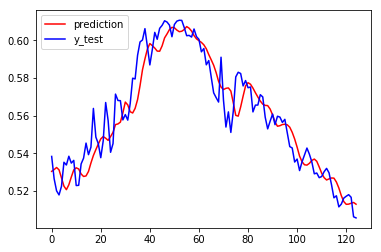

In [64]:
#Prediction VS Real results
import matplotlib.pyplot as plt2


plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()